In segmentation our goal is to extract a specific object or group of objects from an image. In this case those objects are cells.

This task is a binary classification problem. We are given a microscope image. We need to extract the cells from the image. To do this we need to classify each pixel on the image as either being part of a cell or not. The target values are given to us as a black and white mask.

The image could be rgb (3D, 3 channels) or black and white (2D, 1 channel). It's essentially a matrix with values that range between 0 and 255.

The mask is a 2D matrix. It contains only two values that represent either black or white.

Because we treat this as a binary classification problem, we will use the Sigmoid activation function in the last layer of the neural network. We will also use the binary_crossentropy loss function. We will train the network using the images as the input and the masks as the target.

When Predict is run, the model will output a 2D mask. Each pixel in the predicted mask represents the probability that that pixel is part of a cell. We need to convert these probabilities to binary. To do this we threshold the mask by setting all pixel values that are >= 0.5 to 1. All values < 0.5 we set to zero. 

<hr>

In [1]:
import pandas as pd
import numpy as np
import os
import random
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize

# # Don't Show Warning Messages
# import warnings
# warnings.filterwarnings('ignore')

import tensorflow as tf

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Use the GPU more efficiently.
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1

NUM_TEST_IMAGES = 10


## Put Info Into a Dataframe

This dataframe will show the following info:
- id's of all images
- does the image have a mask?
- number of cells on each image
- the blur amount that was aded to each image

In [5]:
# get a list of files in each folder

img_list = os.listdir('Synthetic Cell Images and Masks\BBBC005_v1_images\BBBC005_v1_images')
mask_list = os.listdir('Synthetic Cell Images and Masks\BBBC005_v1_ground_truth/BBBC005_v1_ground_truth')

# create a dataframe
df_images = pd.DataFrame(img_list, columns=['image_id'])

# filter out the non image file that's called .htaccess
df_images = df_images[df_images['image_id'] != '.htaccess']



# Example file name: SIMCEPImages_A13_C53_F1_s23_w2.TIF


# ======================================================
# Add a column showing how many cells are on each image
# ======================================================

def get_num_cells(x):
    # split on the _
    a = x.split('_')
    # choose the third item
    b = a[2] # e.g. C53
    # choose second item onwards and convert to int
    num_cells = int(b[1:])
    
    return num_cells

# create a new column called 'num_cells'
df_images['num_cells'] = df_images['image_id'].apply(get_num_cells)


# ================================================
# Add a column indicating if an image has a mask.
# ================================================

# Keep in mind images and masks have the same file names.

def check_for_mask(x):
    if x in mask_list:
        return 'yes'
    else:
        return 'no'
    
# create a new column called 'has_mask'
df_images['has_mask'] = df_images['image_id'].apply(check_for_mask)



# ===========================================================
# Add a column showing how much blur was added to each image
# ===========================================================

def get_blur_amt(x):
    # split on the _
    a = x.split('_')
    # choose the third item
    b = a[3] # e.g. F1
    # choose second item onwards and convert to int
    blur_amt = int(b[1:])
    
    return blur_amt

# create a new column called 'blur_amt'
df_images['blur_amt'] = df_images['image_id'].apply(get_blur_amt)

In [6]:
df_images.head(10)

,image_id,num_cells,has_mask,blur_amt
1,SIMCEPImages_A01_C1_F1_s01_w1.TIF,1,yes,1
2,SIMCEPImages_A01_C1_F1_s01_w2.TIF,1,yes,1
3,SIMCEPImages_A01_C1_F1_s02_w1.TIF,1,yes,1
4,SIMCEPImages_A01_C1_F1_s02_w2.TIF,1,yes,1
5,SIMCEPImages_A01_C1_F1_s03_w1.TIF,1,yes,1
6,SIMCEPImages_A01_C1_F1_s03_w2.TIF,1,yes,1
7,SIMCEPImages_A01_C1_F1_s04_w1.TIF,1,yes,1
8,SIMCEPImages_A01_C1_F1_s04_w2.TIF,1,yes,1
9,SIMCEPImages_A01_C1_F1_s05_w1.TIF,1,yes,1
10,SIMCEPImages_A01_C1_F1_s05_w2.TIF,1,yes,1


In [7]:
# Print the number of images that have and don't have masks
mask_counts = df_images['has_mask'].value_counts()
print(mask_counts)
# Get the counts
has_mask_count = mask_counts.get('yes', 0)
no_mask_count = mask_counts.get('no', 0)

# Print the counts
print(f"Number of images with masks: {has_mask_count}")
print(f"Number of images without masks: {no_mask_count}")


has_mask
no     18000
yes     1200
Name: count, dtype: int64
Number of images with masks: 1200
Number of images without masks: 18000


## Create a dataframe containing only images that have masks

We will only use this dataframe in the rest of this notebook.

In [8]:
df_masks = df_images[df_images['has_mask'] == 'yes']

# create a new column called mask_id that is just a copy of image_id
df_masks['mask_id'] = df_masks['image_id']

df_masks.shape

C:\Users\VJ\AppData\Local\Temp\ipykernel_29820\2329185241.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_masks['mask_id'] = df_masks['image_id']


(1200, 5)

In [9]:
df_masks.head()

,image_id,num_cells,has_mask,blur_amt,mask_id
1,SIMCEPImages_A01_C1_F1_s01_w1.TIF,1,yes,1,SIMCEPImages_A01_C1_F1_s01_w1.TIF
2,SIMCEPImages_A01_C1_F1_s01_w2.TIF,1,yes,1,SIMCEPImages_A01_C1_F1_s01_w2.TIF
3,SIMCEPImages_A01_C1_F1_s02_w1.TIF,1,yes,1,SIMCEPImages_A01_C1_F1_s02_w1.TIF
4,SIMCEPImages_A01_C1_F1_s02_w2.TIF,1,yes,1,SIMCEPImages_A01_C1_F1_s02_w2.TIF
5,SIMCEPImages_A01_C1_F1_s03_w1.TIF,1,yes,1,SIMCEPImages_A01_C1_F1_s03_w1.TIF


## Create a Test Set

Here we will create a test set containing 10 images. Keras will automatically create a validation set during training.

In [10]:
# create a test set
df_test = df_masks.sample(NUM_TEST_IMAGES, random_state=101)

# Reset the index.
# This is so that we can use loc to access mask id's later.
df_test = df_test.reset_index(drop=True)

# create a list of test images
test_images_list = list(df_test['image_id'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_masks = df_masks[~df_masks['image_id'].isin(test_images_list)]

print(df_masks.shape)
print(df_test.shape)

(1190, 5)
(10, 5)


## Inspect one Image and Mask

Here we want to find out:

- What are the shapes?
- Is the image rgb or black and white?

We need this info to write the code that will process the images and masks into a format that the model requires.

## Image

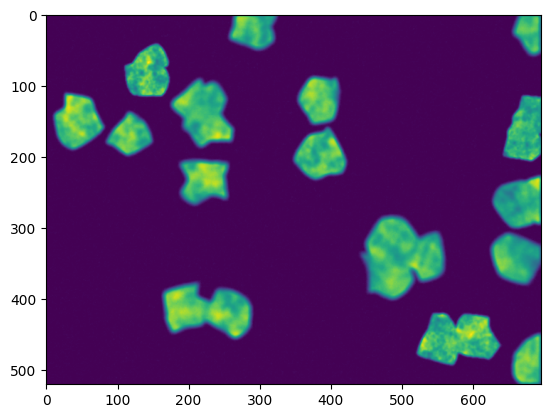

In [11]:
sample_image = 'SIMCEPImages_A06_C23_F1_s11_w2.TIF'
path_image = 'Synthetic Cell Images and Masks/BBBC005_v1_images/BBBC005_v1_images/' + sample_image

# read the image using skimage
image = imread(path_image)

plt.imshow(image)



In [12]:
print('Shape: ', image.shape)
print('Max pixel value: ', image.max())
print('Min pixel value: ', image.min())

Shape:  (520, 696)
Max pixel value:  222
Min pixel value:  0


## Mask

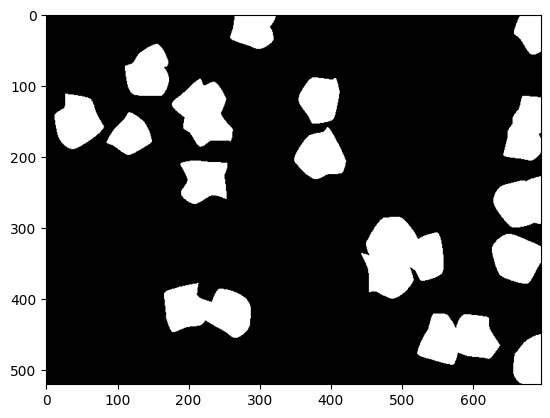

In [13]:
sample_mask = 'SIMCEPImages_A06_C23_F1_s11_w2.TIF'
path_mask = 'Synthetic Cell Images and Masks/BBBC005_v1_ground_truth/BBBC005_v1_ground_truth/' + sample_mask

# read the mask using skimage
mask = imread(path_mask)

plt.imshow(mask, cmap='gray')

In [14]:
print('Shape: ', mask.shape)
print('Max pixel value: ', mask.max())
print('Min pixel value: ', mask.min())

Shape:  (520, 696)
Max pixel value:  255
Min pixel value:  0


The image and its associated mask have the same shape. We see that the image is 2D and not 3D. The mask is 2D. The image has pixel values in the range 0 to 255. The mask has pixel values that are either 0 or 255. 0 is black and 255 is white.

The model requires this input format:<br>

*(num_samples, num_rows, num_columns, num_channels)*

Therefore, we will need to use np.expand_dims to add a channel dimension to both the image and the mask.

Also, the model expects input images and masks to have the same width and height. We will therefore resize both images and the masks to 128 x 128.

## Create X_train, Y_train and X_test

This processing code is the most important part of this kernel. If you see crazy results during training, like negative loss values - then you've most probably made an error on this step. 

In [15]:
# Get lists of images and their masks.
image_id_list = list(df_masks['image_id'])
mask_id_list = list(df_masks['mask_id'])
test_id_list = list(df_test['image_id'])

# Create empty arrays

X_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

Y_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

X_test = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)



In [16]:
# X_train


for i, image_id in enumerate(image_id_list):
    
    path_image = 'Synthetic Cell Images and Masks/BBBC005_v1_images/BBBC005_v1_images/' + image_id
    
    # read the image using skimage
    image = imread(path_image)
    
    # resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    image = np.expand_dims(image, axis=-1)
    
    # insert the image into X_train
    X_train[i] = image
    
X_train.shape

(1190, 128, 128, 1)

In [17]:
# Y_train


for i, mask_id in enumerate(mask_id_list):
    
    path_mask = 'Synthetic Cell Images and Masks/BBBC005_v1_ground_truth/BBBC005_v1_ground_truth/' + mask_id
    
    # read the image using skimage
    mask = imread(path_mask)
    
    # resize the image
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    mask = np.expand_dims(mask, axis=-1)
    
    # insert the image into Y_Train
    Y_train[i] = mask

Y_train.shape

(1190, 128, 128, 1)

In [18]:
# X_test

for i, image_id in enumerate(test_id_list):
    
    path_image = 'Synthetic Cell Images and Masks/BBBC005_v1_images/BBBC005_v1_images/' + image_id
    
    # read the image using skimage
    image = imread(path_image)
    
    # resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    image = np.expand_dims(image, axis=-1)
    
    # insert the image into X_test
    X_test[i] = image
    
X_test.shape

(10, 128, 128, 1)

## Define the Model Architecture

We will use the U-Net arhitecture. U-Net is a cnn that was developed for biomedical image segmentation. It was designed to give good results when only a small number of training images are available. It was also designed to run fast.

Paper: [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)<br>
Olaf Ronneberger, Philipp Fischer, Thomas Brox

Take note that the images are normalized inside the model using a lamda layer.

In [19]:
from tensorflow import keras

# from keras.models import Model, load_model
# from keras.layers import Input
# from keras.layers.core import Dropout, Lambda
# from keras.layers.convolutional import Conv2D, Conv2DTranspose
# from keras.layers.pooling import MaxPooling2D
# from keras.layers.merge import concatenate
# from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras import backend as K

from keras.models import Model, load_model
from keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import backend as K

In [20]:



inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

## Train the Model

We will let Keras automatically create a 10% validation set during training. I haven't specified a metric, but for segmentation problems I've often seen custom metrics like IOU or dice coef be used.

```
tensorboard --logdir=logs/fit
```

write in cmd 

In [21]:
filepath = "model.h5"

earlystopper = EarlyStopping(patience=10, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [earlystopper, checkpoint, tensorboard_callback]

history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=callbacks_list)

Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 0.1102 - accuracy: 0.9509
Epoch 1: val_loss improved from inf to 0.05523, saving model to model.h5
67/67 [==============================] - 16s 148ms/step - loss: 0.1102 - accuracy: 0.9509 - val_loss: 0.0552 - val_accuracy: 0.9765
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 0.0356 - accuracy: 0.9849
Epoch 2: val_loss improved from 0.05523 to 0.04394, saving model to model.h5
67/67 [==============================] - 6s 85ms/step - loss: 0.0356 - accuracy: 0.9849 - val_loss: 0.0439 - val_accuracy: 0.9814
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 0.0299 - accuracy: 0.9872
Epoch 3: val_loss improved from 0.04394 to 0.03773, saving model to model.h5
67/67 [==============================] - 6s 84ms/step - loss: 0.0299 - accuracy: 0.9872 - val_loss: 0.0377 - val_accuracy: 0.9840
Epoch 4/50
67/67 [==============================] - ETA: 0s - loss: 0.0269 - accuracy: 0.9885
Epoch

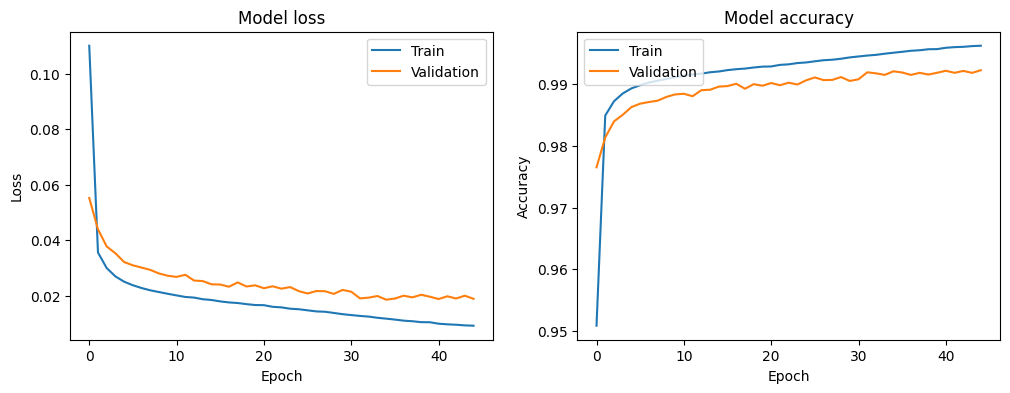

In [22]:

# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [23]:
model.save('model.h5')  # creates a HDF5 file 'my_model.h5'

## Make a Prediction

In [24]:
# Make a prediction

# use the best epoch
model.load_weights('model.h5')

test_preds = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [25]:
# Threshold the predictions

preds_test_thresh = (test_preds >= 0.5).astype(np.uint8)

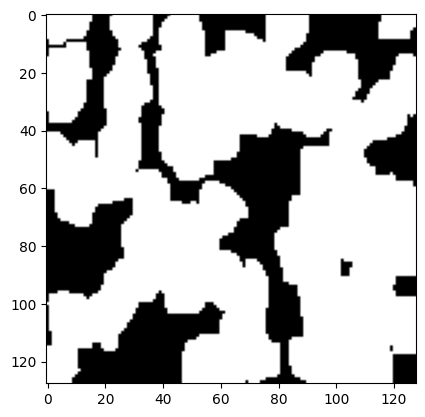

In [26]:
# Display a thresholded mask

test_img = preds_test_thresh[5, :, :, 0]

plt.imshow(test_img, cmap='gray')

## Inspect the Results

Here we will display 3 test images, their true masks and the masks that the model predicted for those images.

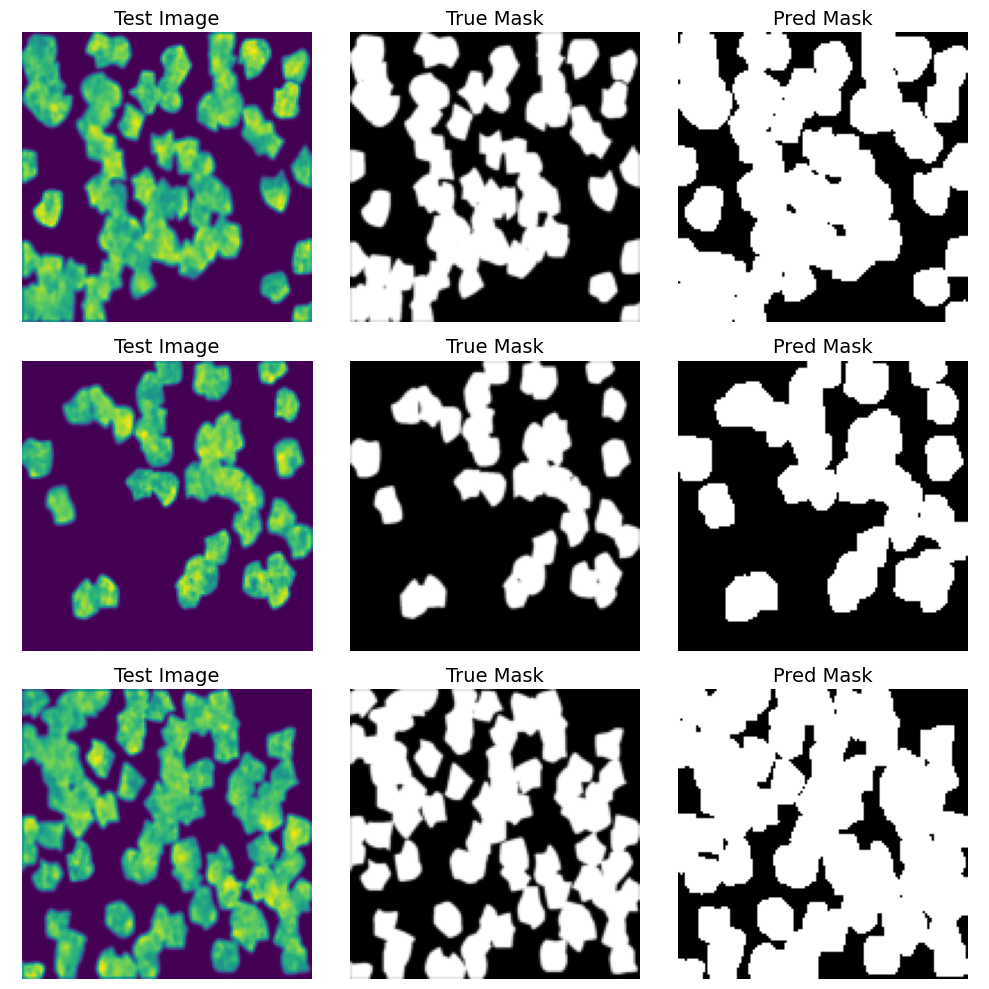

In [27]:
# set up the canvas for the subplots
plt.figure(figsize=(10,10))
plt.axis('Off')

# Our subplot will contain 3 rows and 3 columns
# plt.subplot(nrows, ncols, plot_number)


# == row 1 ==

# image
plt.subplot(3,3,1)
test_image = X_test[1, :, :, 0]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,2)
mask_id = df_test.loc[1,'mask_id']
path_mask = 'Synthetic Cell Images and Masks/BBBC005_v1_ground_truth/BBBC005_v1_ground_truth/' + mask_id
mask = imread(path_mask)
mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,3)
test_mask = preds_test_thresh[1, :, :, 0]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')


# == row 2 ==

# image
plt.subplot(3,3,4)
test_image = X_test[2, :, :, 0]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,5)
mask_id = df_test.loc[2,'mask_id']
path_mask = 'Synthetic Cell Images and Masks/BBBC005_v1_ground_truth/BBBC005_v1_ground_truth/' + mask_id
mask = imread(path_mask)
mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,6)
test_mask = preds_test_thresh[2, :, :, 0]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')

# == row 3 ==

# image
plt.subplot(3,3,7)
test_image = X_test[3, :, :, 0]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,8)
mask_id = df_test.loc[3,'mask_id']
path_mask = 'Synthetic Cell Images and Masks/BBBC005_v1_ground_truth/BBBC005_v1_ground_truth/' + mask_id
mask = imread(path_mask)
mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,9)
test_mask = preds_test_thresh[3, :, :, 0]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')


plt.tight_layout()
plt.show()

This basic setup is producing good results. The model is identifying the cells quite well. However, the cells on the predicted masks are slightly larger than the actual cells and the boundaries are not smooth. Could this be because of the blur that was added to each image? This is something you could try to improve. Maybe try tuning some parameters, use custom loss or even try a different architecture.